# Spike count data regression

### Table of contents

1. [**Synthetic heteroscedastic count data**](#data)
2. [**Model recovery**](#recover)
3. [**Fitting the UCM**](#fit)
4. [**Evaluating the UCM**](#eval)


In [1]:
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


import sys
sys.path.append("..")


import neuroprob as nprb
from neuroprob import utils
from neuroprob.likelihoods.discrete import gen_NB


dev = nprb.inference.get_device()  # PyTorch device, gpu 0 by default if available

PyTorch version: 1.13.0+cu117
Using device: cuda:0


In [2]:
# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plots.make_cmap([blue, white, red], 'weight_map')

<a id="synthetic"></a>
## 1. Synthetic heteroscedastic count data

In [3]:
def HDC_bumps(theta, A, invbeta, b, theta_0):
    """
    parameters have shape (neurons,)
    :return:
        rates of shape (..., neurons, eval_pts)
    """
    return A[:, None] * np.exp(
        (np.cos(theta[..., None, :] - theta_0[:, None]) - 1) / invbeta[:, None]) + b[:, None]


In [4]:
timesamples = 10000
rng = np.random.default_rng(123)  # seed RNG

# random walk
hd_t = np.empty(timesamples)
hd_t[0] = 0
rn = rng.normal(size=(timesamples,))
for k in range(1, timesamples):
    hd_t[k] = hd_t[k-1] + 0.1*rn[k]
    
hd_t = hd_t % (2*np.pi)

In [5]:
tbin = 0.05
neurons = 50

# von Mises fields
p_c = rng.normal(size=(neurons,))**2 + 1.0
p_a = np.maximum(0.0, 30.0 + 0.1*rng.normal(size=(neurons,)))
p_b = 0.2*rng.normal(size=(neurons,))**2 + 0.3
p_z = np.linspace(0, 2*np.pi, neurons+1)[:-1]

_angle_0 = rng.permutation(p_z)
_beta = (0.2 * rng.normal(size=(neurons,)))**2 + 0.01
_rate_0 = rng.uniform(size=(neurons,)) * 30.0
_b = rng.uniform(size=(neurons,)) * 1.

# rate tuning curve
vm_rate = lambda x: HDC_bumps(x, p_a, p_b, p_c, p_z)

# dispersion tuning curve
vm_disp = lambda x: HDC_bumps(x, _rate_0, 1e6 * np.ones_like(1./_beta), _b, _angle_0)

In [6]:
steps = 1000
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)

rate = vm_rate(covariates)
r = vm_disp(covariates)

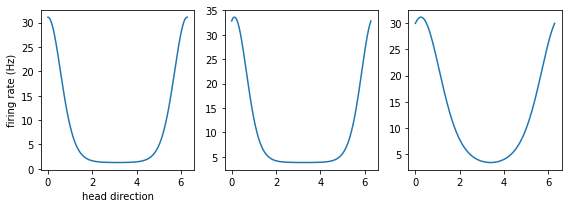

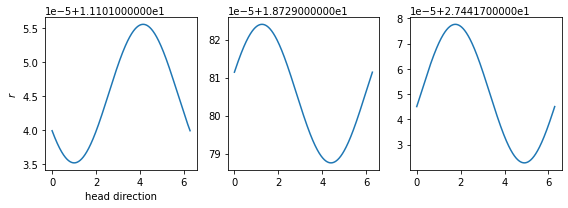

In [7]:
fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, rate[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')
    
fig.tight_layout()
plt.show()


fig, axes = plt.subplots(1, len(show_neurons), figsize=(8, 3))

for k, ne in enumerate(show_neurons):
    line, = axes[k].plot(covariates, r[ne, :])
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$r$')
    
fig.tight_layout()
plt.show()

In [8]:
# generate data
rate_t = vm_rate(hd_t)
r_t = vm_disp(hd_t)

syn_train = gen_NB(rng, rate_t*tbin, r_t)

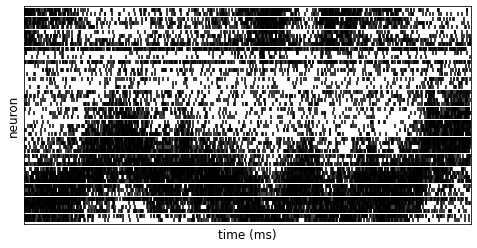

In [9]:
T = 1000

fig, ax = plt.subplots(figsize=(8,4))
utils.plots.raster_plot((fig, ax), syn_train[:, :T], T, tbin*1000, neurons, markersize=10)
utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

<a id="recover"></a>
## 2. Model recovery


<a id='recover_fit'></a>
### 2.1 Fitting within model class

In [10]:
out_dims = neurons

modules = []
for _ in range(2):
    # kernel
    l = 2.*torch.ones(1, out_dims)
    v = 1.*torch.ones(out_dims)

    krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
    krn_2 = nprb.kernels.SquaredExponential(
        input_dims=len(l), lengthscale=l, \
        track_dims=[0], topology='ring', f='softplus', \
        tensor_type=torch.float
    )

    kernel = nprb.kernels.Product(krn_1, krn_2)

    # inputs
    input_data = [torch.from_numpy(hd_t)]
    input_group = nprb.inputs.input_group()
    input_group.set_XZ(input_data, timesamples, batch_info=1000)

    # inducing points
    num_induc = 12
    Xu = np.array(
        [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
    ).T[None, ...].repeat(out_dims, axis=0)
    inducing_points = nprb.mappings.inducing_points(
        out_dims, torch.from_numpy(Xu), jitter=1e-5)

    # mapping
    in_dims = Xu.shape[-1]

    modules.append(
        nprb.mappings.SVGP(
            in_dims, neurons, kernel, inducing_points=inducing_points, 
            whiten=True, jitter=1e-4, mean=torch.zeros(neurons), learn_mean=True
        )
    )

rate_gp, disp_gp = modules

# likelihood
likelihood = nprb.likelihoods.discrete.hNegative_binomial(tbin, neurons, 'exp', disp_gp)
likelihood.set_Y(torch.from_numpy(syn_train), batch_info=1000) 

# assemble
gpr = nprb.inference.VI_optimized(input_group, rate_gp, likelihood)
gpr.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): hNegative_binomial(
    (dispersion_mapping): SVGP(
      (kernel): Product(
        (kern0): Constant()
        (kern1): SquaredExponential()
      )
      (induc_pts): inducing_points()
    )
  )
)

In [11]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.95)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(1000, loss_margin=-1e1, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/1000 [00:00<?, ?it/s]


Stopped at epoch 167.


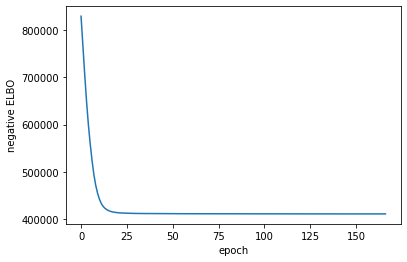

In [12]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='recover_post'></a>
### 2.2 Posterior tuning curves

In [13]:
# tuning curves
steps= 100
show_neurons = [0, 1, 2]
covariates = np.linspace(0, 2*np.pi, steps)[None, :]  # (dims, timesteps)

lower, mean, upper = [
    p.cpu().numpy() for p in utils.model.posterior_rate(
        rate_gp, likelihood.f, torch.from_numpy(covariates), 1000, show_neurons)
]

dlower, dmean, dupper = [
    p.cpu().numpy() for p in utils.model.posterior_rate(
        disp_gp, likelihood.dispersion_mapping_f, torch.from_numpy(covariates), 1000, show_neurons)
]

rate = vm_rate(covariates[0])
r = vm_disp(covariates[0])

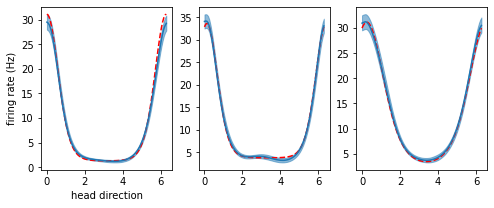

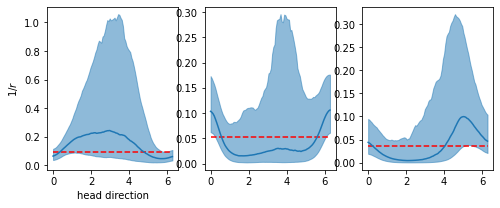

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], rate[n], 'r--')
    line, = axes[k].plot(covariates[0], mean[k])
    axes[k].fill_between(
        covariates[0], lower[k],
        upper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel('firing rate (Hz)')

fig.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for k, n in enumerate(show_neurons):
    
    axes[k].plot(covariates[0], 1/r[n], 'r--')
    line, = axes[k].plot(covariates[0], dmean[k])
    axes[k].fill_between(
        covariates[0], dlower[k],
        dupper[k], color=line.get_color(), alpha=0.5
    )
    if k == 0:
        axes[k].set_xlabel('head direction')
        axes[k].set_ylabel(r'$1/r$')

fig.tight_layout()
plt.show()

<a id="fit"></a>
## 3. Fitting the UCM


In [15]:
C = 3
out_dims = C*neurons

# kernel
l = 5.*torch.ones(1, out_dims)
v = torch.ones(out_dims)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0], topology='ring', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inputs
input_data = [torch.from_numpy(hd_t)]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, timesamples, batch_info=1000)

# inducing points
num_induc = 8
Xu = np.array(
    [np.linspace(0, 2*np.pi, num_induc+1)[:-1]]
).T[None, ...].repeat(out_dims, axis=0)
inducing_points = nprb.mappings.inducing_points(out_dims, torch.from_numpy(Xu))


# mapping
in_dims = Xu.shape[-1]

gp = nprb.mappings.SVGP(
    in_dims, out_dims, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-4, mean=torch.zeros(out_dims), learn_mean=True
)

# likelihood
basis_mode = 'el'  # exponential-linear
max_count = syn_train.max()
likelihood = nprb.likelihoods.discrete.Universal(neurons, C, basis_mode, 'identity', max_count)
likelihood.set_Y(torch.from_numpy(syn_train), batch_info=1000) 

# assemble
gpr = nprb.inference.VI_optimized(input_group, gp, likelihood)
gpr.to(dev)

VI_optimized(
  (input_group): input_group()
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Universal(
    (lsoftm): LogSoftmax(dim=-1)
    (mapping_net): Parallel_Linear(in_features=6, out_features=18, channels=50, bias=True)
  )
)

In [16]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.99)
opt_lr_dict = {
    'default': 1e-2, 
}

gpr.set_optimizers(optim.Adam, sch, 100, opt_lr_dict)

annealing = lambda x: 1.0
losses = gpr.fit(3000, loss_margin=-1e1, margin_epochs=30, kl_anneal_func=annealing, 
                 cov_samples=1, ll_samples=10, ll_mode='MC')

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 404.


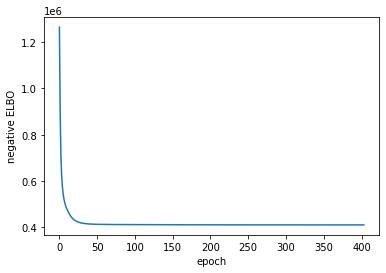

In [17]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='eval'></a>
## 4. Evaluating the UCM


In [18]:
def get_q_Z(P, spike_binned):
    deq_noise = np.random.uniform(size=spike_binned.shape)

    cumP = np.cumsum(P, axis=-1)  # T, K
    tt = np.arange(spike_binned.shape[0])
    quantiles = (
        cumP[tt, spike_binned.astype(int)] - P[tt, spike_binned.astype(int)] * deq_noise
    )
    Z = utils.stats.q_to_Z(quantiles)
    return quantiles, Z

<a id='eval_fit'></a>
### 4.1 Goodness-of-fit metrics
Apart from the likelihood score, a more direct measure of goodness-of-fit is given by the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) adapted to count distributions. We compute the predictive spike count distribution given input covariates and then compute the quantiles of the observed spike counts. These are obtained from the training data, and will thus show us how well the model was able to fit in an absolute sense. We can turn these into $Z$-scores (which will be unit normal distributed if the model describes observations well).

In [19]:
# quantiles, Z scores
P_ = []
for b in range(gpr.input_group.batches):
    covariates, _ = gpr.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = utils.model.compute_UCM_P_count(gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(neurons):
    batch_edge, _, _ = gpr.likelihood.batch_info
    spike_binned = gpr.likelihood.all_spikes[trial, n, :].numpy()
    q_, Z_ = get_q_Z(P[n, ...], spike_binned)
    q.append(q_)
    Z.append(Z_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)
Z = np.array(Z)  # Z scores of shape (neurons, timesteps)

We can obtain the Kolmogorov-Smirnov test statistic $T_{KS}$, and the dispersion statistic $T_{DS}$ as well (see paper). These statistics are computed per neuron and reflect single neuron goodness-of-fit measures. The $T_{KS}$ statistic seems to be roughly distributed as the sampling distribution under the null model, i.e. if the model generated the data this would be the distribution of $T_{KS}$ observed for an infinite number of repetitions of random data draws.

In [20]:
T_DS_bn = []
T_KS_bn = []
for qq in q:
    T_DS, T_KS, sign_DS, sign_KS, p_DS, p_KS = utils.stats.KS_statistics(qq, alpha=0.05, alpha_s=0.05)
    T_DS_bn.append(T_DS)
    T_KS_bn.append(T_KS)

T_DS_bn = np.array(T_DS_bn)  # (neurons,)
T_KS_bn = np.array(T_KS_bn)


x = np.linspace(0, 0.02, 100)
bins = np.linspace(0, 0.02, 50)
f = utils.stats.KS_sampling_dist(x, len(q[0]))

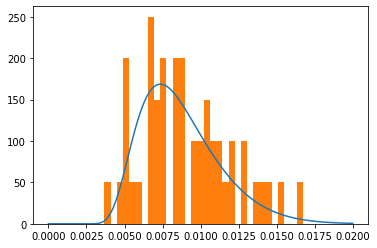

In [21]:
plt.plot(x, f)
plt.hist(T_KS_bn, bins=bins, density=True)
plt.show()

<a id='SCD'></a>
### 4.2 Computing spike count distributions

We can compute the spike count distribution conditioned on input covariates, and in this way we can explore the neural tuning over a slice through input space. We set all other covariates at the mean values of the observed time series in the dataset.

In [22]:
hd_sweep = np.linspace(0, 2*np.pi, 100)
covariates = torch.from_numpy(hd_sweep)[None, None, :, None]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = utils.model.compute_UCM_P_count(
        gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior

P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)
lower, mean, upper = utils.stats.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


# true parameters
rate = vm_rate(hd_sweep)
r = vm_disp(hd_sweep)

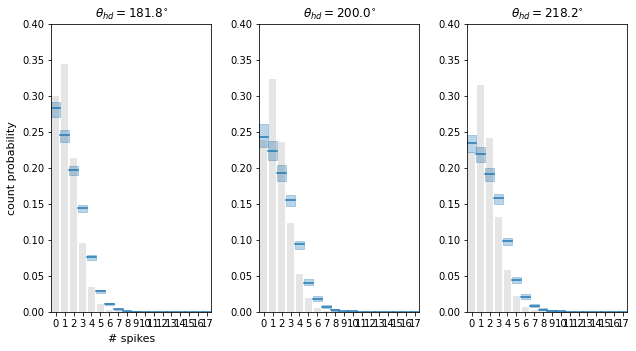

In [23]:
ne = 30  # select neuron to plot


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    
    # true count distribution
    K = P_mc.shape[-1]
    bins = np.arange(K+1)
    gt_P = utils.stats.nb_count_prob(
        bins, rate[ne, step_ind]*tbin, 1/r[ne, step_ind], 1.0)
    
    ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    for k in range(K):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2)*mean.numpy()[ne, step_ind, k]
        YY_l = np.ones(2)*lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2)*upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)
        
        ax.bar(XX_[0]+0.5, gt_P[k], color='k', alpha=0.1)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(K))
    
    if en == 0:
        ax.set_ylabel('count probability', fontsize=11, labelpad=5)
        ax.set_xlabel('# spikes', labelpad=5, fontsize=11)

plt.show()

Conventional tuning curves show mean firing rate as a function of some covariate. We can plot those by computing the mean of the count distribution.

In [24]:
K = P.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / tbin  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

lower, mean, upper = utils.stats.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
flower, fmean, fupper = utils.stats.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])


# true tuning
gt_rate = rate
gt_FF = 1 + rate * tbin / r

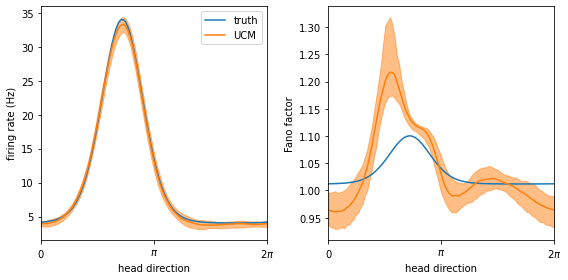

In [25]:
ne = 18  # select neuron to plot


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(hd_sweep, gt_rate[ne], label='truth')
line, = axes[0].plot(hd_sweep, mean[ne, :].numpy(), label='UCM')
axes[0].fill_between(
    hd_sweep, lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
axes[0].set_ylabel('firing rate (Hz)')
axes[0].set_xlabel('head direction')
axes[0].set_xlim(0, 2*np.pi)
axes[0].set_xticks([0, np.pi, 2*np.pi])
axes[0].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
axes[0].legend()

axes[1].plot(hd_sweep, gt_FF[ne])
line, = axes[1].plot(hd_sweep, fmean[ne, :].numpy())
axes[1].fill_between(
    hd_sweep, flower[ne, :].numpy(), fupper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
axes[1].set_ylabel('Fano factor')
axes[1].set_xlabel('head direction')
axes[1].set_xlim(0, 2*np.pi)
axes[1].set_xticks([0, np.pi, 2*np.pi])
axes[1].set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

fig.tight_layout()
plt.show()

<a id='ucm_inspect'></a>
### 4.3 Inspecting model parameters

We can load all the kernel hyperparameters, which govern how quickly the neural tuning fluctuates with changes in covariates. The kernel module is a nested module (a product kernel with separable kernels over each covariate dimension). For the circular lengthscale, values way above $2\pi$ indicate little variation in the GP function with head direction, i.e. it is a redundant degree of freedom w.r.t. the head direction (approximately a constant function).

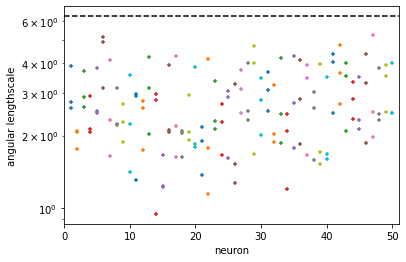

In [26]:
lengthscales = gpr.mapping.kernel.kern1.lengthscale.reshape(neurons, -1).data.cpu().numpy()
C = lengthscales.shape[-1]

fig, ax = plt.subplots()

for n in range(neurons):
    ax.scatter((n + 1)*np.ones(C), lengthscales[n, :], marker='+', s=10)
    
ax.plot([0, neurons+1], [2*np.pi, 2*np.pi], 'k--')
ax.set_xlim([0, neurons+1])
ax.set_yscale('log')

ax.set_ylabel('angular lengthscale')
ax.set_xlabel('neuron')
    
plt.show()

The above only holds for one covariate dimension that we looked at. To look at the intrinsic degree of freedom for a neuron, it may be more informative and convenient to look at the softmax weights and biases that connect the GP functions to the spike count distribution. We now load the pre-softmax weights and biases. Each neuron has its own set of weights and biases $W_n$ and $\mathbf{b}_n$. Note we used a exponential-quadratic expansion for $\phi(\cdot)$. This expansion combines the quadratic basis expansion with an exponential mapping, i.e. for a vector $\mathbf{f} = (f_1, f_2)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_1^2, f_2^2, e^{f_1}, e^{f_2}, f_1 f_2)
$$

and for a vector $\mathbf{f} = (f_1, f_2, f_3)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, f_1^2, f_2^2, f_3^2, e^{f_1}, e^{f_2}, e^{f_3}, f_1 f_2, f_2 f_3, f_1 f_3)
$$

and so on. The last example here corresponds to the case of $C = 3$ as in the model that we loaded. The probability of spike count $k$ for neuron $n$ is then computed as 

$$
P_{nk} = \text{softmax}\left( W_n \cdot \phi(\mathbf{f}_n) + \mathbf{b}_n \right)_k
$$

Different basis expansions $\phi(\cdot)$ are defined in ```scripts/lib/models.py```.

In [27]:
print(gpr.likelihood.mapping_net.weight.shape)  # (neuron, count, phi(f) dimension)
print(gpr.likelihood.mapping_net.bias.shape)  # (neuron, count)

torch.Size([50, 18, 6])
torch.Size([50, 18])


In [28]:
ne = 20  # select neuron
Wn = gpr.likelihood.mapping_net.weight[ne, :, :].data.cpu().numpy()
ne = 20  # select neuron
bn = gpr.likelihood.mapping_net.bias[ne, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())

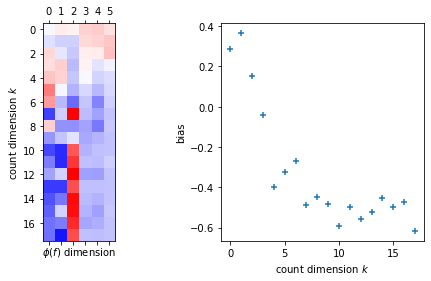

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))


im = axes[0].matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map)
axes[0].set_xlabel(r'$\phi(f)$ dimension')
axes[0].set_ylabel(r'count dimension $k$')

axes[1].scatter(np.arange(bn.shape[0]), bn, marker='+', s=30)
axes[1].set_ylabel('bias')
axes[1].set_xlabel(r'count dimension $k$')

    
plt.show()